In [1]:
import json, glob, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
rpath = 'D:/starnet/network_data/Feedback_128x90.00_ClusterNet_no_remnant/region_log/phx256-1'
rfiles = glob.glob('%s/*'%(rpath))

with open(rfiles[0], 'r') as f:
    data = json.load(f)

print(data['post_state'].keys())
print(type(data['post_state']['p2_stars']), len(data['post_state']['p2_stars']))


dict_keys(['current_time', 'p3_stars', 'p2_stars', 'p3_remnants', 'p3_bh', 'p3_bh_birth', 'p3_bh_masses', 'remnant_birth', 'remnant_masses', 'p3_formation_time', 'p3_masses', 'p2_formation_time', 'p2_masses', 'p3_lifetimes', 'enriched_formation_metal', '%s_rloc'])
<class 'list'> 0


In [4]:
p2s = []
p2form = []
dts = []
high_p2_pids = []
neg_dt = []
dt_cnt = [[],[]]
p2mass = []
p3mass = []
nop2_cnt = 0
all_cnt = 0
prior_p2 = 0
nopostp3 = 0
for rfile in rfiles:
    with open(rfile, 'r') as f:
        data = json.load(f)
    ftime = min(data['post_state']['p3_formation_time']) if len(data['post_state']['p3_formation_time']) > 0 else 1e20
    ftime = min(ftime, min(data['post_state']['remnant_birth']) if data['post_state']['remnant_birth'] else -1)
    npriorp2 = len(data['prior_state']['p2_stars'])
    if ftime < 0:
        nopostp3 += 1
    if npriorp2:
        prior_p2 += 1
    if ftime > 0 and npriorp2 == 0:
        all_cnt += 1
        if sorted(data['post_state']['p2_stars']) == sorted(data['prior_state']['p2_stars']):
            nop2_cnt += 1
        dts += [data['post_state']['current_time'] - data['prior_state']['current_time']]
        # if dt < 30:
        p2s += [len(data['post_state']['p2_stars'])] 
        p2form += [t - data['prior_state']['current_time'] 
                    if data['post_state']['p2_stars'][i] not in data['prior_state']['p2_stars'] else -1 
                    for i, t in enumerate(data['post_state']['p2_formation_time'])]
        p3mass += [
            sum(data['post_state']['p3_masses'])]
        p2mass += [sum(data['post_state']['p2_masses']) - sum(data['prior_state']['p2_masses'])]
        if len(data['post_state']['p2_stars']) > 50:
            high_p2_pids.append(
                int(os.path.split(rfile)[-1].split('_')[-1].split('.')[0])
            )

        if np.any(np.array([t - ftime for t in data['post_state']['p2_formation_time']]) < 0) and ftime > 0:
            neg_dt.append(
                int(os.path.split(rfile)[-1].split('_')[-1].split('.')[0])
            )
            dt_cnt[0].append(min([t - data['prior_state']['current_time'] for t in data['post_state']['p2_formation_time']]))
            dt_cnt[1].append(len(data['post_state']['p2_stars']))

print('n_prior_p2:',prior_p2, 
        '\nn_nop2: ', nop2_cnt, 
        '\nn_nop3 in post: ',nopostp3, 
        '\nall qualifying regions: ',all_cnt)
print(high_p2_pids)
print(neg_dt)

n_prior_p2: 0 
n_nop2:  326 
n_nop3 in post:  7 
all qualifying regions:  326
[]
[]


C:\Users\azton\Anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
<ipython-input-5-b2538416502d>:17: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[3].set_yscale('log')


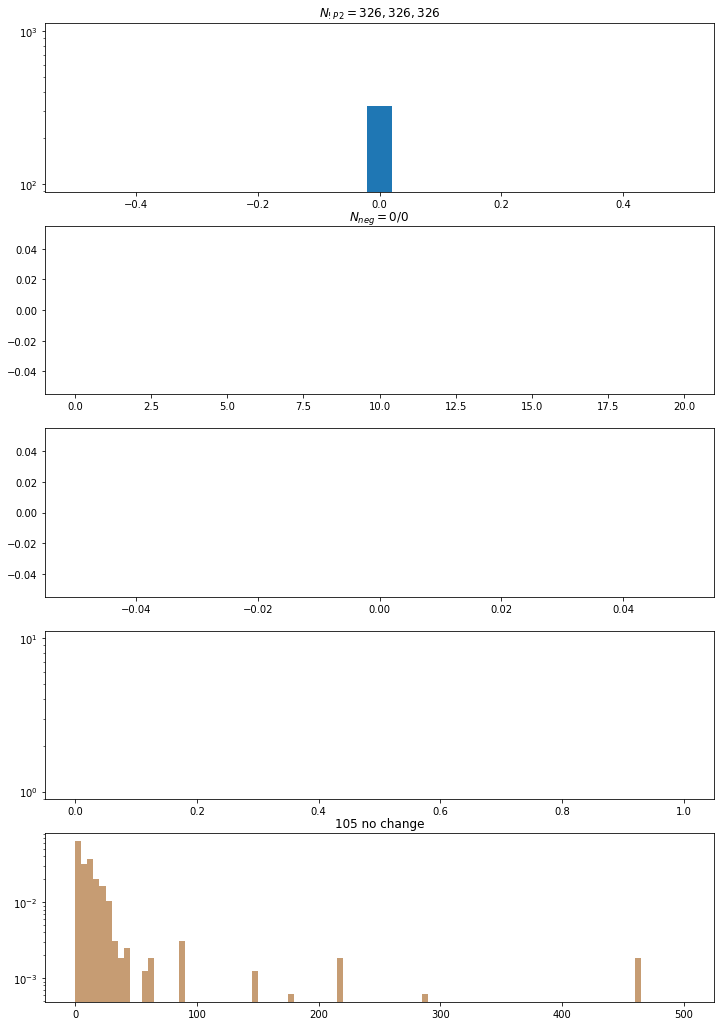

In [5]:
fig, ax = plt.subplots(5, figsize=(12,18))

p2s = np.array(p2s)
np2forms = (p2s[p2s == 0]).size
nfew = (p2s[p2s < 5]).size
nlots = (p2s[p2s < 15]).size
p2form = np.array(p2form)
p2mass = np.array(p2mass)[np.array(p2mass) > 1]
n_neg = p2form[p2form < 0].size
nop3chng = (np.array(p3mass)[np.array(p3mass) == 0]).size

ax[0].hist(p2s, bins=25)
ax[1].hist(p2form, bins=25, range=[0,20], cumulative = True, histtype='step', density=True)
# ax[1].set_yscale('log')
ax[2].scatter(dt_cnt[0], dt_cnt[1])
ax[3].hist(p2mass, bins=25)
ax[3].set_yscale('log')
# ax3t = ax[3].twiny()
hist, p3bins, _ = ax[4].hist(p3mass, bins=100, range=[0,500], alpha = 0.5, color='tab:blue', density=True)
p3mass = np.array(p3mass)
p3nop2 = p3mass[p2s == 0]
ax[4].hist(p3nop2, bins=p3bins, alpha=0.5, color='tab:orange', density=True)
ax[4].set_yscale('log')

ax[4].set_title('%d no change'%nop3chng)
ax[0].set_yscale('log')
ax[0].set_title('$N_{!P2} = %d, %d, %d$'%(np2forms, nfew, nlots))
ax[1].set_title('$N_{neg} = %d/%d$'%(len(neg_dt), len(p2form)))

plt.savefig('images/cluster_regions_analysis.pdf')

In [10]:
print(p2form[p2form > 0].size, p2form[p2form == 0].size)

581 0


(333, 30)


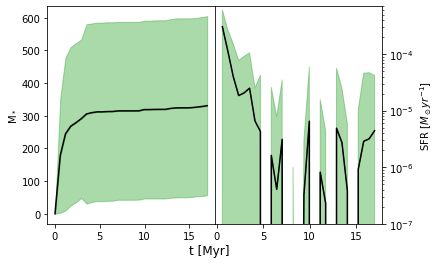

In [51]:
# plotting p3 mass as fn of time in regions:
meanvals = []
fig, ax = plt.subplots(1,2)
for rfile in rfiles:
    timebins = np.linspace(0, 17, 30)
    binvals = np.zeros((31))
    with open(rfile, 'r') as f:
        data = json.load(f)
    tnow = data['prior_state']['current_time']
    tbins = np.digitize([t-tnow for t in data['post_state']['p3_formation_time']], timebins)
    for i, t in enumerate(tbins):
        binvals[t] += data['post_state']['p3_masses'][i]
    tbins = np.digitize([t-tnow for t in data['post_state']['remnant_birth']], timebins)
    for i, t in enumerate(tbins):
        binvals[t] += data['post_state']['remnant_masses'][i]
    binvals = np.array([binvals[:i].sum() for i in range(1, binvals.size)])
    meanvals.append(binvals.tolist())
#     ax[0].plot(timebins, binvals, alpha=0.1, color='tab:blue')

sfrs = []
for r in meanvals:
    sfr = [(r[i]-r[i-1])/dt/1e6 for i in range(1,len(r))]
    sfrs.append(sfr)
meanvals = np.array(meanvals)
print(meanvals.shape)
meanstd = meanvals.std(0)
meanvals = meanvals.mean(0)
dt = timebins[1]-timebins[0]

meansfr = np.array(sfrs).mean(0)
stdsfr = np.array(sfrs).std(0)

ax[0].plot(timebins, meanvals, alpha=1.0, color='k')
ax[0].fill_between(timebins, meanvals, meanvals + meanstd, color='tab:green',alpha=0.4)
ax[0].fill_between(timebins, meanvals, meanvals - meanstd, color='tab:green',alpha=0.4)
# for sfr in sfrs:
ax[1].plot(timebins[1:], meansfr, alpha=1, color='k')
ax[1].fill_between(timebins[1:], meansfr, meansfr+stdsfr, color='tab:green', alpha=0.4)
ax[1].fill_between(timebins[1:], meansfr, meansfr-stdsfr, color='tab:green', alpha=0.4)
ax[1].yaxis.tick_right()
ax[0].set_ylabel('M$_*$')
fig.supxlabel('t [Myr]')
ax[1].yaxis.set_label_position('right')
ax[1].set_ylabel('SFR [$M_\odot yr^{-1}$]')
ax[1].set_ylim(1e-7, 7e-4)
ax[1].set_yscale('log')
plt.subplots_adjust(wspace=0.0)

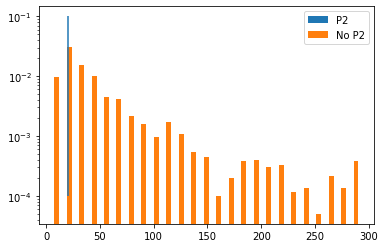

In [11]:
withp2_mass = []
nop2_mass = []
for rfile in rfiles:
    with open(rfile, 'r') as f:
        data = json.load(f)
    if len(data['post_state']['p2_masses']) > 0:
        withp2_mass += data['post_state']['p3_masses']
        withp2_mass += data['post_state']['remnant_masses']
        withp2_mass += data['post_state']['p3_bh_masses']
        
    else:
        nop2_mass += data['post_state']['p3_masses']
        nop2_mass += data['post_state']['remnant_masses']
        nop2_mass += data['post_state']['p3_bh_masses']
        
fig, ax = plt.subplots()
# bins = np.array([i for i in range(11,41)] + [i for i in range(140, 261, 5)])
ax.hist([withp2_mass, nop2_mass], bins=25, label = ['P2','No P2'], density=True)
ax.vlines([20], 1e-4, 1e-1)
ax.legend()
ax.set_yscale('log')


In [8]:
349/850


0.41058823529411764